# Liver-Cirrhosis-Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.decomposition import PCA

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [15]:
def check_for_dupes_nans(df:pd.DataFrame):
  
  amount_of_dupes = df.duplicated().sum()
  print(f"Null Count: {df.isna().sum()}")
  print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        
        
        
        
        
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def val_grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', model)
    ])
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)    
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_test_pred)
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
                "Best Parameters": grid_search.best_params_
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/liver_cirrhosis.csv")
df

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,D,D-penicillamine,16736,F,N,Y,Y,Y,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,C,D-penicillamine,16990,F,N,Y,N,N,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


# Check For Nulls and Dupes

In [16]:
check_for_dupes_nans(df)

Null Count: N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Dupe Count: 15361


# Dupe Count is over 15K

In [14]:
print(f"Non Duplicated values is: {len(df) - df.duplicated().sum()}")

Non Duplicated values is: 9639


In [17]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

Class=1, Count=3025, Percentage=31.383%
Class=2, Count=3308, Percentage=34.319%
Class=3, Count=3306, Percentage=34.298%


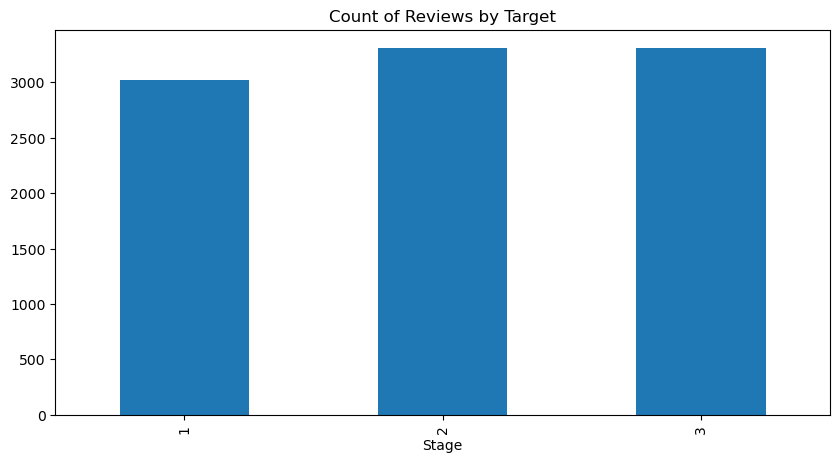

In [18]:
check_class_imbalance(df,df['Stage'], 'Stage')

# Balanced Dataset

In [19]:
df.dtypes

N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage              int64
dtype: object

In [20]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000,9639.000000
mean,1910.982571,18429.717606,3.228571,371.706706,3.496118,97.027569,1973.572709,122.317487,123.587337,253.787605,10.713328,2.029152
std,1093.620373,3693.953156,4.512278,197.824339,0.382319,73.108854,1827.063380,47.653515,55.206301,95.740700,0.922026,0.809956
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1103.000000,15628.000000,0.800000,271.000000,3.290000,51.000000,1031.000000,89.900000,93.000000,188.000000,10.000000,1.000000
50%,1690.000000,18628.000000,1.300000,369.510563,3.520000,97.648387,1713.000000,122.556346,124.702128,249.000000,10.600000,2.000000
75%,2598.000000,20819.000000,3.300000,369.510563,3.760000,102.000000,1982.655769,134.850000,125.000000,307.000000,11.100000,3.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.000000


In [30]:
categorical_features, numeric_features = df.select_dtypes(include="object"), df.select_dtypes(include=["int64", "float64"]).drop("Stage", axis=1)

In [26]:
for col in categorical_features.columns:
  print(f"Unqiue column values for col: {col} = {categorical_features[col].unique()}")

Unqiue column values for col: Status = ['C' 'D' 'CL']
Unqiue column values for col: Drug = ['Placebo' 'D-penicillamine']
Unqiue column values for col: Sex = ['F' 'M']
Unqiue column values for col: Ascites = ['N' 'Y']
Unqiue column values for col: Hepatomegaly = ['Y' 'N']
Unqiue column values for col: Spiders = ['N' 'Y']
Unqiue column values for col: Edema = ['N' 'Y' 'S']


# Visuals

<AxesSubplot:>

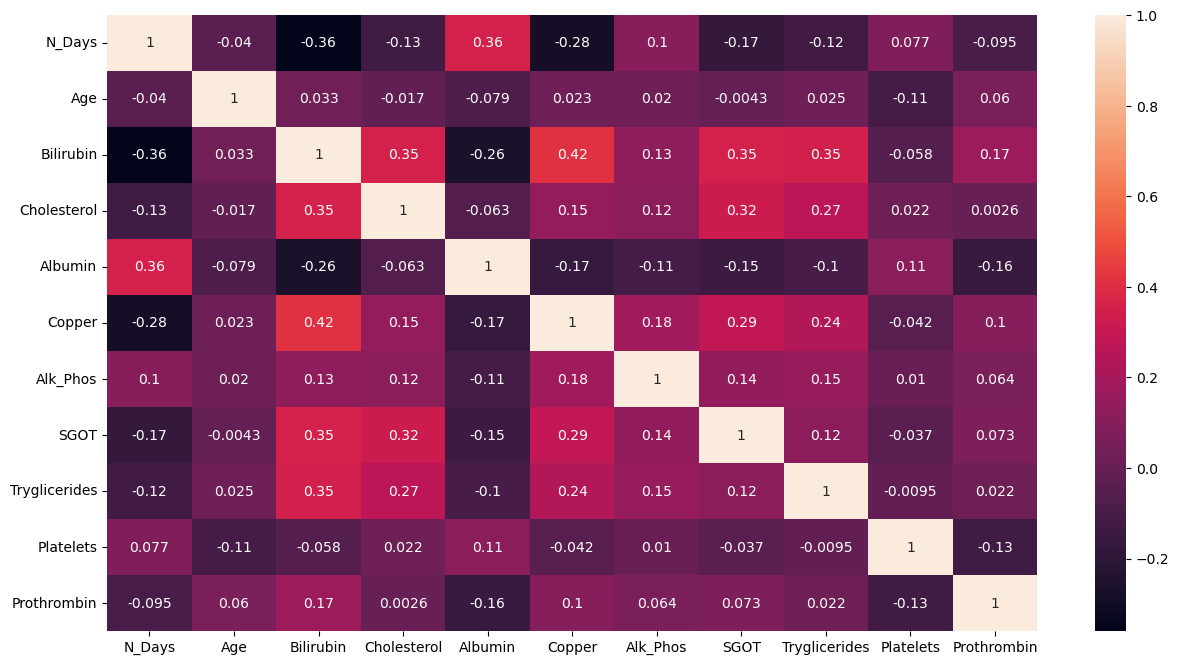

In [31]:
plt.figure(figsize=(15,8))
sns.heatmap(data=numeric_features.corr(), annot=True)

# Some features seem to be correlated together, this could potentially interfere in the modeling process. This could also be stasitical noise due to number of feartures. We will have to explore.

# One Hot Encoding categorical features

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


numeric_features_columns = numeric_features.columns

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("power_tranformer",PowerTransformer())]
)


categorical_features = categorical_features.columns
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)